In [1]:
import torch
import numpy as np
import pandas as pd
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch.nn as nn

from lightning_models import ForecastNextKDays_Boosted
from torchinfo import summary

In [2]:
model = ForecastNextKDays_Boosted(data_path = 'Dataset/IKCO1.csv',      
                        split = [0.80, 0.10, 0.10],
                        batch_size = 128,
                        learning_rate = 5e-4,
                        weight_decay = 0.0001)


summary(model, input_size = (128, 21, 5))

Layer (type:depth-idx)                   Output Shape              Param #
ForecastNextKDays_Boosted                --                        --
├─AELSTM: 1-1                            [128, 1]                  --
│    └─Encoder: 2-1                      [128, 21, 2]              --
│    │    └─LSTM: 3-1                    [128, 21, 3]              120
│    │    └─LSTM: 3-2                    [128, 21, 2]              56
│    └─Decoder: 2-2                      [128, 21, 5]              --
│    │    └─LSTM: 3-3                    [128, 21, 3]              84
│    │    └─LSTM: 3-4                    [128, 21, 5]              200
│    └─forecastLSTM: 2-3                 [128, 1]                  --
│    │    └─LSTM: 3-5                    [128, 21, 128]            463,872
│    │    └─Linear: 3-6                  [128, 1]                  129
├─L1Loss: 1-2                            --                        --
├─MeanAbsoluteError: 1-3                 --                        --
Total p

In [3]:
checkpoint_callback = ModelCheckpoint(dirpath = 'forecast-boosted',
                                    filename = "checkpoint.ckpt",
                                    every_n_epochs = 1,
                                    monitor = 'val_loss',
                                    mode = 'min')

early_stop_callback = EarlyStopping(monitor = "val_loss",
                                    min_delta = 0.00,
                                    patience = 30,
                                    verbose = False,
                                    mode = "min")

logger = TensorBoardLogger('forecast-boosted-logs/', name = 'forecast-boosted', version = 1)

In [4]:
trainer = Trainer(
    default_root_dir = 'forecast-boosted-logs/',
    gpus = (1 if torch.cuda.is_available() else 0),
    callbacks = [checkpoint_callback, early_stop_callback],
    max_epochs = 200,
    logger = logger)

trainer.fit(model = model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type              | Params
----------------------------------------------------------
0 | model               | AELSTM            | 464 K 
1 | loss                | L1Loss            | 0     
2 | mean_absolute_error | MeanAbsoluteError | 0     
----------------------------------------------------------
464 K     Trainable params
0         Non-trainable params
464 K     Total params
1.858     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\trainer.py:1927: PossibleUserWarning: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 199: 100%|██████████| 27/27 [00:15<00:00,  1.75it/s, loss=0.0452, v_num=1, train_loss=0.0509]


In [5]:
trainer.test(datamodule = model)

c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\trainer.py:1444: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:412: LightningDeprecationWarning: `LightningDataModule.on_save_checkpoint` was deprecated in v1.6 and will be removed in v1.8. Use `state_dict` instead.
  rank_zero_deprecation(
c:\Anaconda\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:417: LightningDeprecationWarning: `LightningDataModule.on_load_checkpoint` was deprecated in v1.6 and will be removed in v1.8. Use `load_state_dict` instead.
  rank_zero_deprecation(
Restoring states from the checkpoint path at C:\Users\Yegyanathan V\Desktop\Python\De

Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           MAE              0.1763196736574173
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'MAE': 0.1763196736574173}]

In [14]:
from utils import create_dataset

model = model.load_from_checkpoint("forecast-boosted\checkpoint.ckpt.ckpt")
df = pd.read_csv('Dataset\IKCO1.csv', index_col = [0])

df_X = df[['<OPEN>','<HIGH>','<LOW>','<CLOSE>','<VOL>']] 
df_y = df[['<CLOSE>']]

df_X_scaled = model.scaler_X.transform(df_X)


inputs, actuals = create_dataset(df_X_scaled, df_y, 21, 10)

In [15]:
print(inputs.shape, actuals.shape)

(4066, 21, 5) (4066, 1)


In [16]:
inputs = torch.tensor(inputs.astype(np.float32))
inputs

tensor([[[2.0843e-01, 1.7390e-01, 2.1794e-01, 2.0865e-01, 4.3901e-04],
         [2.0865e-01, 1.7462e-01, 2.1783e-01, 2.0843e-01, 3.8199e-04],
         [2.0843e-01, 1.7372e-01, 2.1760e-01, 2.0811e-01, 6.6190e-04],
         ...,
         [2.3911e-01, 2.0054e-01, 2.4992e-01, 2.3976e-01, 1.9753e-03],
         [2.3976e-01, 2.0342e-01, 2.5036e-01, 2.4405e-01, 2.8186e-03],
         [2.4405e-01, 2.1746e-01, 2.5493e-01, 2.6078e-01, 3.7331e-04]],

        [[2.0865e-01, 1.7462e-01, 2.1783e-01, 2.0843e-01, 3.8199e-04],
         [2.0843e-01, 1.7372e-01, 2.1760e-01, 2.0811e-01, 6.6190e-04],
         [2.0811e-01, 1.7813e-01, 2.1772e-01, 2.1390e-01, 3.1825e-04],
         ...,
         [2.3976e-01, 2.0342e-01, 2.5036e-01, 2.4405e-01, 2.8186e-03],
         [2.4405e-01, 2.1746e-01, 2.5493e-01, 2.6078e-01, 3.7331e-04],
         [2.6078e-01, 2.3222e-01, 2.8056e-01, 2.7837e-01, 3.8441e-03]],

        [[2.0843e-01, 1.7372e-01, 2.1760e-01, 2.0811e-01, 6.6190e-04],
         [2.0811e-01, 1.7813e-01, 2.1772e-01,

In [17]:
model.eval()
with torch.no_grad():
    
    output, _ = model(inputs)

preds = output.squeeze()
preds = np.array(preds) 
preds

array([0.23702747, 0.24348094, 0.25364685, ..., 0.72729856, 0.72839   ,
       0.72907686], dtype=float32)

In [18]:
print(preds.shape)

(4066,)


In [19]:
predictions = pd.DataFrame(preds, columns = ['preds'])
predictions[['preds']] = model.scaler_y.inverse_transform(predictions[['preds']])

In [20]:
predictions['actuals'] = actuals
predictions.head(10)

,preds,actuals
0,3064.570068,3598.0
1,3124.729248,3598.0
2,3219.496094,3598.0
3,3320.214111,3598.0
4,3395.577637,3598.0
5,3426.050293,3598.0
6,3411.397705,3598.0
7,3380.436035,3598.0
8,3367.793213,3598.0
9,3383.287354,3576.0


<AxesSubplot:>

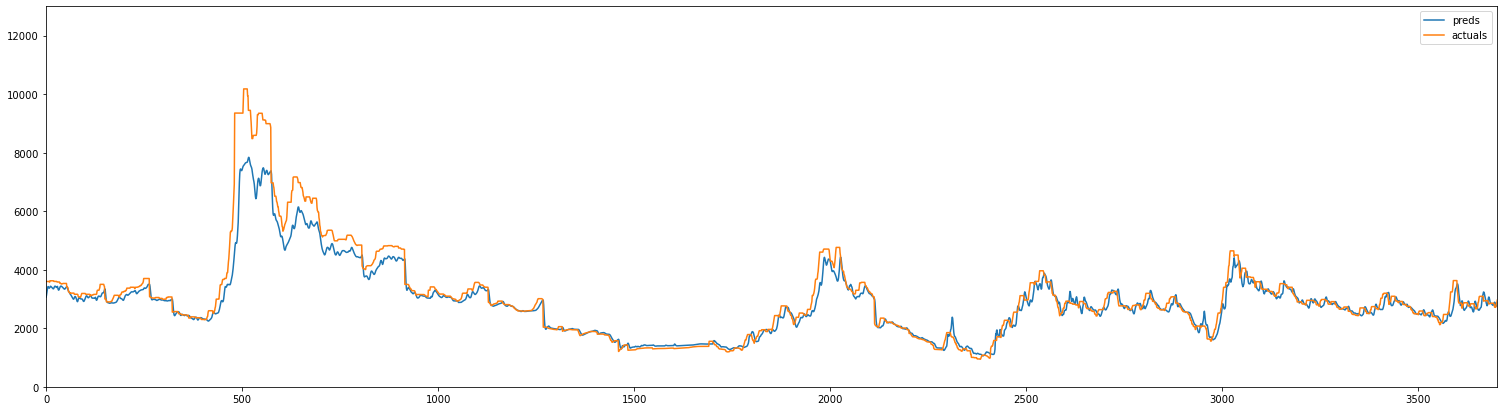

In [28]:
predictions.plot(figsize = (26, 7), xlim = [0,3700], ylim = [0,13000])